In [52]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
from simpegskytem import ProblemSkyTEM, GlobalAEMSurveyTD, GlobalSkyTEM, get_skytem_survey
import pandas as pd
from scipy.interpolate import NearestNDInterpolator

In [53]:
from simpegskytem import Utils

In [54]:
mesh, models = Mesh.TensorMesh.read_vtk('./time-lapse-synthetic.vtr')

In [55]:
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt("./data/waveform_hm_312.txt")
waveform_lm_312 = np.loadtxt("./data/waveform_lm_312.txt")
time_input_currents_hm_312 = waveform_hm_312[:,0] 
input_currents_hm_312 = waveform_hm_312[:,1]
time_input_currents_lm_312 = waveform_lm_312[:,0] 
input_currents_lm_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt("./data/time_gates")
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

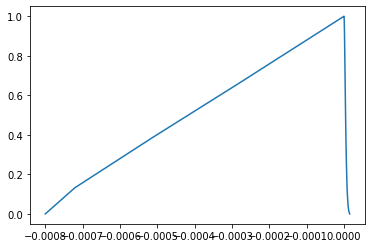

In [56]:
plt.plot(time_input_currents_lm_312, input_currents_lm_312)

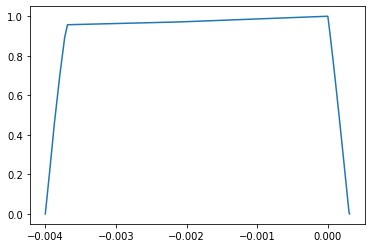

In [57]:
plt.plot(time_input_currents_hm_312, input_currents_hm_312)

In [58]:
rho_1 = models['rho_1']
rho_3 = models['rho_3']
active_inds = mesh.gridCC[:,2] < 0.

In [59]:
tmp = rho_1.copy()
tmp[~active_inds.astype(bool)] = np.nan

In [60]:
from matplotlib.colors import LogNorm

(<matplotlib.collections.QuadMesh at 0x2ab5c0cc1950>,)

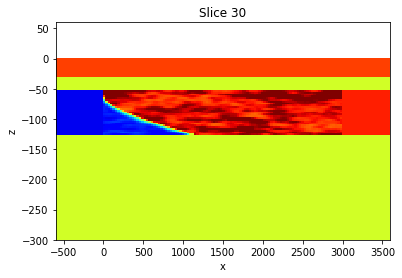

In [61]:
mesh.plotSlice(rho_1, clim=(0.3, 100), normal='y', pcolorOpts={'norm':LogNorm(), 'cmap':'jet'})

In [62]:
xmin, xmax = 0, 2800
# generate survey
x_inds = np.argwhere(np.logical_and(mesh.vectorCCx > xmin, mesh.vectorCCx < xmax))
x = mesh.vectorCCx[x_inds][::2]
y = np.zeros_like(x)
src_height = 40.
z = np.ones_like(x) * 0.
src_locations = np.c_[x, y, z + src_height]
rx_locations = np.c_[x+13.25, y, z+2.+ src_height]
n_sounding = src_locations.shape[0]
topo = np.c_[x, y, z*0.]

In [63]:
survey = get_skytem_survey(
    topo,
    src_locations,
    rx_locations,
    times_hm_312,
    time_input_currents_hm_312,
    input_currents_hm_312,
    25.,
    src_type="VMD",
    rx_type="dBzdt",    
    moment_type="dual",        
    time_dual_moment=times_lm_312,
    time_input_currents_dual_moment=time_input_currents_lm_312,
    input_currents_dual_moment=input_currents_lm_312,
    base_frequency_dual_moment=210.,
    wave_type="general",    
    field_type="secondary",    
)

simulation = GlobalSkyTEM(
    mesh, 
    sigma=1./rho_1, 
    actv=active_inds, 
    parallel_option='multiprocess'
)
simulation.pair(survey)

>> Set parameters


In [64]:
print (survey.n_sounding)

47


In [65]:
# write inputs to the disk
simulation.write_inputs_on_disk_pool()

In [66]:
%time data = simulation.forward(1./rho_1)

CPU times: user 40 ms, sys: 303 ms, total: 343 ms
Wall time: 13.6 s


In [67]:
np.save('./data/data_1', data)

In [68]:
DATA = data.reshape((times_hm_312.size+times_lm_312.size, n_sounding), order='F')

In [69]:
DATA_HM = -DATA[:times_hm_312.size,:]
DATA_LM = -DATA[times_hm_312.size:,:]

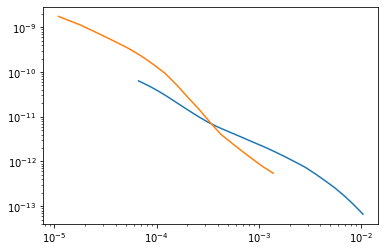

In [70]:
i_sounding = 3
plt.loglog(times_hm_312, DATA_HM[:,i_sounding])
plt.loglog(times_lm_312, DATA_LM[:,i_sounding])

In [71]:
data.size * 2

4230